<a href="https://colab.research.google.com/github/Looma1116/Kaggle-Study_Seungjoon_Lee/blob/main/CartpoleDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [263]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install -U colabgymrender


In [264]:
# !apt update
# !pip install pyvirtualdisplay
# !pip3 install pyvirtualdisplay
# !apt install xvfb
# !pip install xvfbwrapper

In [265]:
import gym
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.optimizers import Adam

In [266]:
# from gym import logger as gymlogger
# from gym.wrappers import Monitor
# import glob
# import io
# import base64
# from IPython.display import HTML
# from pyvirtualdisplay import Display
# from IPython import display as ipythondisplay
from colabgymrender.recorder import Recorder
# def show_video(i):
#     mp4list = glob.glob('video/*.mp4')
#     if len(mp4list) > 0:
#         mp4 = mp4list[i]
#         video = io.open(mp4, 'r+b').read()
#         encoded = base64.b64encode(video)
#         ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
#                 loop controls style="height: 400px;">
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#              </video>'''.format(encoded.decode('ascii'))))
#     else: 
#       print("could not find video")

# def wrap_env(env):
#     env = Monitor(env, './video', force=True)
#     return env

# display = Display(visible = 0, size=(1400,900))
# display.start()


In [267]:
class DQN(tf.keras.Model):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc3 = Dense(24, activation='relu')
        self.fc_out = Dense(action_size, kernel_initializer=RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        q = self.fc_out(x)
        return q

In [268]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        #Hyperparameters
        self.discount_factor = 0.99
        self.learning_rate = 0.005
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 32
        self.train_start = 150
        self.memory = deque(maxlen=800)

        self.model = DQN(action_size)
        self.target_model = DQN(action_size)
        self.optimizer = Adam(learning_rate=self.learning_rate)
		
        self.update_target_model()

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        return random.randrange(self.action_size) if (np.random.rand() <= self.epsilon) else np.argmax(self.model.predict(state))
    
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.array([sample[0][0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            predicts = self.model(states)
            one_hot_action = tf.one_hot(actions, self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)

            target_predicts = self.target_model(next_states)
            target_predicts = tf.stop_gradient(target_predicts)

            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1 - dones) * self.discount_factor * max_q
            loss = tf.reduce_mean(tf.square(targets - predicts))

        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))

In [269]:
env = gym.make('CartPole-v1')
directory = './video'
env = Recorder(env, directory)

episode:   0 | score avg 29.00 | memory length:   29 | epsilon: 1.0000
episode:   1 | score avg 28.10 | memory length:   49 | epsilon: 1.0000
episode:   2 | score avg 27.09 | memory length:   67 | epsilon: 1.0000
episode:   3 | score avg 25.78 | memory length:   81 | epsilon: 1.0000
episode:   4 | score avg 24.30 | memory length:   92 | epsilon: 1.0000
episode:   5 | score avg 25.47 | memory length:  128 | epsilon: 1.0000
episode:   6 | score avg 23.93 | memory length:  138 | epsilon: 1.0000
episode:   7 | score avg 22.93 | memory length:  152 | epsilon: 0.9970
episode:   8 | score avg 23.04 | memory length:  176 | epsilon: 0.9733
episode:   9 | score avg 23.84 | memory length:  207 | epsilon: 0.9436


episode:  10 | score avg 25.35 | memory length:  246 | epsilon: 0.9075
episode:  11 | score avg 24.82 | memory length:  266 | epsilon: 0.8895
episode:  12 | score avg 23.54 | memory length:  278 | epsilon: 0.8789
episode:  13 | score avg 25.48 | memory length:  321 | epsilon: 0.8419
episode:  14 | score avg 30.63 | memory length:  398 | epsilon: 0.7795
episode:  15 | score avg 33.37 | memory length:  456 | epsilon: 0.7355
episode:  16 | score avg 35.13 | memory length:  507 | epsilon: 0.6989
episode:  17 | score avg 35.82 | memory length:  549 | epsilon: 0.6702
episode:  18 | score avg 33.94 | memory length:  566 | epsilon: 0.6589
episode:  19 | score avg 36.24 | memory length:  623 | epsilon: 0.6224


episode:  20 | score avg 36.22 | memory length:  659 | epsilon: 0.6003
episode:  21 | score avg 36.30 | memory length:  696 | epsilon: 0.5785
episode:  22 | score avg 34.17 | memory length:  711 | epsilon: 0.5699
episode:  23 | score avg 38.35 | memory length:  787 | epsilon: 0.5282
episode:  24 | score avg 45.22 | memory length:  800 | epsilon: 0.4746
episode:  25 | score avg 47.29 | memory length:  800 | epsilon: 0.4442
episode:  26 | score avg 43.46 | memory length:  800 | epsilon: 0.4403
episode:  27 | score avg 40.22 | memory length:  800 | epsilon: 0.4354
episode:  28 | score avg 50.70 | memory length:  800 | epsilon: 0.3766
episode:  29 | score avg 59.53 | memory length:  800 | epsilon: 0.3277


episode:  30 | score avg 60.27 | memory length:  800 | epsilon: 0.3065
episode:  31 | score avg 59.55 | memory length:  800 | epsilon: 0.2907
episode:  32 | score avg 62.39 | memory length:  800 | epsilon: 0.2662
episode:  33 | score avg 71.25 | memory length:  800 | epsilon: 0.2288
episode:  34 | score avg 71.23 | memory length:  800 | epsilon: 0.2131
episode:  35 | score avg 66.40 | memory length:  800 | epsilon: 0.2083
episode:  36 | score avg 61.76 | memory length:  800 | epsilon: 0.2042
episode:  37 | score avg 56.99 | memory length:  800 | epsilon: 0.2013
episode:  38 | score avg 53.59 | memory length:  800 | epsilon: 0.1968
episode:  39 | score avg 50.23 | memory length:  800 | epsilon: 0.1929


episode:  40 | score avg 46.81 | memory length:  800 | epsilon: 0.1898
episode:  41 | score avg 50.83 | memory length:  800 | epsilon: 0.1740
episode:  42 | score avg 48.14 | memory length:  800 | epsilon: 0.1698
episode:  43 | score avg 45.03 | memory length:  800 | epsilon: 0.1670
episode:  44 | score avg 46.13 | memory length:  800 | epsilon: 0.1579
episode:  45 | score avg 49.31 | memory length:  800 | epsilon: 0.1460
episode:  46 | score avg 53.98 | memory length:  800 | epsilon: 0.1327
episode:  47 | score avg 54.18 | memory length:  800 | epsilon: 0.1254
episode:  48 | score avg 55.87 | memory length:  800 | epsilon: 0.1168
episode:  49 | score avg 59.08 | memory length:  800 | epsilon: 0.1070


episode:  50 | score avg 60.17 | memory length:  800 | epsilon: 0.0997
episode:  51 | score avg 66.15 | memory length:  800 | epsilon: 0.0885
episode:  52 | score avg 72.04 | memory length:  800 | epsilon: 0.0781
episode:  53 | score avg 72.73 | memory length:  800 | epsilon: 0.0721
episode:  54 | score avg 75.26 | memory length:  800 | epsilon: 0.0654
episode:  55 | score avg 76.44 | memory length:  800 | epsilon: 0.0599
episode:  56 | score avg 78.89 | memory length:  800 | epsilon: 0.0542
episode:  57 | score avg 79.90 | memory length:  800 | epsilon: 0.0496
episode:  58 | score avg 82.91 | memory length:  800 | epsilon: 0.0444
episode:  59 | score avg 90.52 | memory length:  800 | epsilon: 0.0379


episode:  60 | score avg 94.77 | memory length:  800 | epsilon: 0.0332
episode:  61 | score avg 98.49 | memory length:  800 | epsilon: 0.0290
episode:  62 | score avg 100.14 | memory length:  800 | epsilon: 0.0259
episode:  63 | score avg 103.53 | memory length:  800 | epsilon: 0.0226
episode:  64 | score avg 116.48 | memory length:  800 | epsilon: 0.0179
episode:  65 | score avg 122.03 | memory length:  800 | epsilon: 0.0151
episode:  66 | score avg 124.53 | memory length:  800 | epsilon: 0.0130
episode:  67 | score avg 126.17 | memory length:  800 | epsilon: 0.0113
episode:  68 | score avg 126.86 | memory length:  800 | epsilon: 0.0100
episode:  69 | score avg 128.57 | memory length:  800 | epsilon: 0.0100


episode:  70 | score avg 129.81 | memory length:  800 | epsilon: 0.0100
episode:  71 | score avg 134.63 | memory length:  800 | epsilon: 0.0100
episode:  72 | score avg 137.27 | memory length:  800 | epsilon: 0.0100
episode:  73 | score avg 136.74 | memory length:  800 | epsilon: 0.0100
episode:  74 | score avg 144.37 | memory length:  800 | epsilon: 0.0100
episode:  75 | score avg 142.33 | memory length:  800 | epsilon: 0.0100
episode:  76 | score avg 138.40 | memory length:  800 | epsilon: 0.0100
episode:  77 | score avg 140.36 | memory length:  800 | epsilon: 0.0100
episode:  78 | score avg 141.52 | memory length:  800 | epsilon: 0.0100
episode:  79 | score avg 141.47 | memory length:  800 | epsilon: 0.0100


episode:  80 | score avg 141.02 | memory length:  800 | epsilon: 0.0100
episode:  81 | score avg 143.02 | memory length:  800 | epsilon: 0.0100
episode:  82 | score avg 146.62 | memory length:  800 | epsilon: 0.0100
episode:  83 | score avg 149.96 | memory length:  800 | epsilon: 0.0100
episode:  84 | score avg 154.06 | memory length:  800 | epsilon: 0.0100
episode:  85 | score avg 154.65 | memory length:  800 | epsilon: 0.0100
episode:  86 | score avg 154.59 | memory length:  800 | epsilon: 0.0100
episode:  87 | score avg 157.43 | memory length:  800 | epsilon: 0.0100
episode:  88 | score avg 160.09 | memory length:  800 | epsilon: 0.0100
episode:  89 | score avg 165.18 | memory length:  800 | epsilon: 0.0100


episode:  90 | score avg 170.96 | memory length:  800 | epsilon: 0.0100
episode:  91 | score avg 179.66 | memory length:  800 | epsilon: 0.0100
episode:  92 | score avg 182.70 | memory length:  800 | epsilon: 0.0100
episode:  93 | score avg 186.63 | memory length:  800 | epsilon: 0.0100
episode:  94 | score avg 204.37 | memory length:  800 | epsilon: 0.0100
episode:  95 | score avg 230.93 | memory length:  800 | epsilon: 0.0100
episode:  96 | score avg 257.84 | memory length:  800 | epsilon: 0.0100
episode:  97 | score avg 277.05 | memory length:  800 | epsilon: 0.0100
episode:  98 | score avg 256.05 | memory length:  800 | epsilon: 0.0100
episode:  99 | score avg 233.24 | memory length:  800 | epsilon: 0.0100


episode: 100 | score avg 211.72 | memory length:  800 | epsilon: 0.0100
episode: 101 | score avg 197.95 | memory length:  800 | epsilon: 0.0100
episode: 102 | score avg 181.95 | memory length:  800 | epsilon: 0.0100
episode: 103 | score avg 164.66 | memory length:  800 | epsilon: 0.0100
episode: 104 | score avg 150.29 | memory length:  800 | epsilon: 0.0100
episode: 105 | score avg 136.26 | memory length:  800 | epsilon: 0.0100
episode: 106 | score avg 124.14 | memory length:  800 | epsilon: 0.0100
episode: 107 | score avg 139.92 | memory length:  800 | epsilon: 0.0100
episode: 108 | score avg 142.23 | memory length:  800 | epsilon: 0.0100
episode: 109 | score avg 142.01 | memory length:  800 | epsilon: 0.0100


episode: 110 | score avg 159.41 | memory length:  800 | epsilon: 0.0100
episode: 111 | score avg 191.67 | memory length:  800 | epsilon: 0.0100
episode: 112 | score avg 202.50 | memory length:  800 | epsilon: 0.0100
episode: 113 | score avg 232.25 | memory length:  800 | epsilon: 0.0100
episode: 114 | score avg 259.02 | memory length:  800 | epsilon: 0.0100
episode: 115 | score avg 283.12 | memory length:  800 | epsilon: 0.0100
episode: 116 | score avg 304.81 | memory length:  800 | epsilon: 0.0100
episode: 117 | score avg 299.23 | memory length:  800 | epsilon: 0.0100
episode: 118 | score avg 319.31 | memory length:  800 | epsilon: 0.0100
episode: 119 | score avg 332.08 | memory length:  800 | epsilon: 0.0100


episode: 120 | score avg 318.97 | memory length:  800 | epsilon: 0.0100
episode: 121 | score avg 305.97 | memory length:  800 | epsilon: 0.0100
episode: 122 | score avg 293.17 | memory length:  800 | epsilon: 0.0100
episode: 123 | score avg 280.36 | memory length:  800 | epsilon: 0.0100
episode: 124 | score avg 268.82 | memory length:  800 | epsilon: 0.0100
episode: 125 | score avg 259.54 | memory length:  800 | epsilon: 0.0100
episode: 126 | score avg 236.68 | memory length:  800 | epsilon: 0.0100
episode: 127 | score avg 229.32 | memory length:  800 | epsilon: 0.0100
episode: 128 | score avg 228.78 | memory length:  800 | epsilon: 0.0100
episode: 129 | score avg 208.61 | memory length:  800 | epsilon: 0.0100


episode: 130 | score avg 189.05 | memory length:  800 | epsilon: 0.0100
episode: 131 | score avg 173.94 | memory length:  800 | epsilon: 0.0100
episode: 132 | score avg 158.85 | memory length:  800 | epsilon: 0.0100
episode: 133 | score avg 144.26 | memory length:  800 | epsilon: 0.0100
episode: 134 | score avg 139.54 | memory length:  800 | epsilon: 0.0100
episode: 135 | score avg 129.48 | memory length:  800 | epsilon: 0.0100
episode: 136 | score avg 117.73 | memory length:  800 | epsilon: 0.0100
episode: 137 | score avg 107.96 | memory length:  800 | epsilon: 0.0100
episode: 138 | score avg 100.16 | memory length:  800 | epsilon: 0.0100
episode: 139 | score avg 91.65 | memory length:  800 | epsilon: 0.0100


episode: 140 | score avg 89.78 | memory length:  800 | epsilon: 0.0100
episode: 141 | score avg 86.11 | memory length:  800 | epsilon: 0.0100
episode: 142 | score avg 89.09 | memory length:  800 | epsilon: 0.0100
episode: 143 | score avg 87.59 | memory length:  800 | epsilon: 0.0100
episode: 144 | score avg 85.23 | memory length:  800 | epsilon: 0.0100
episode: 145 | score avg 88.80 | memory length:  800 | epsilon: 0.0100
episode: 146 | score avg 103.42 | memory length:  800 | epsilon: 0.0100
episode: 147 | score avg 111.08 | memory length:  800 | epsilon: 0.0100
episode: 148 | score avg 121.17 | memory length:  800 | epsilon: 0.0100
episode: 149 | score avg 159.06 | memory length:  800 | epsilon: 0.0100


episode: 150 | score avg 193.15 | memory length:  800 | epsilon: 0.0100
episode: 151 | score avg 194.54 | memory length:  800 | epsilon: 0.0100
episode: 152 | score avg 205.88 | memory length:  800 | epsilon: 0.0100
episode: 153 | score avg 235.29 | memory length:  800 | epsilon: 0.0100
episode: 154 | score avg 261.76 | memory length:  800 | epsilon: 0.0100
episode: 155 | score avg 258.39 | memory length:  800 | epsilon: 0.0100
episode: 156 | score avg 252.15 | memory length:  800 | epsilon: 0.0100
episode: 157 | score avg 255.73 | memory length:  800 | epsilon: 0.0100
episode: 158 | score avg 280.16 | memory length:  800 | epsilon: 0.0100
episode: 159 | score avg 297.94 | memory length:  800 | epsilon: 0.0100


episode: 160 | score avg 285.05 | memory length:  800 | epsilon: 0.0100
episode: 161 | score avg 262.25 | memory length:  800 | epsilon: 0.0100
episode: 162 | score avg 256.82 | memory length:  800 | epsilon: 0.0100
episode: 163 | score avg 233.84 | memory length:  800 | epsilon: 0.0100
episode: 164 | score avg 224.95 | memory length:  800 | epsilon: 0.0100
episode: 165 | score avg 205.96 | memory length:  800 | epsilon: 0.0100
episode: 166 | score avg 188.86 | memory length:  800 | epsilon: 0.0100
episode: 167 | score avg 181.68 | memory length:  800 | epsilon: 0.0100
episode: 168 | score avg 165.31 | memory length:  800 | epsilon: 0.0100
episode: 169 | score avg 158.48 | memory length:  800 | epsilon: 0.0100


episode: 170 | score avg 143.73 | memory length:  800 | epsilon: 0.0100
episode: 171 | score avg 141.56 | memory length:  800 | epsilon: 0.0100
episode: 172 | score avg 177.40 | memory length:  800 | epsilon: 0.0100
episode: 173 | score avg 209.66 | memory length:  800 | epsilon: 0.0100
episode: 174 | score avg 238.70 | memory length:  800 | epsilon: 0.0100
episode: 175 | score avg 264.83 | memory length:  800 | epsilon: 0.0100
episode: 176 | score avg 256.34 | memory length:  800 | epsilon: 0.0100
episode: 177 | score avg 242.51 | memory length:  800 | epsilon: 0.0100
episode: 178 | score avg 220.26 | memory length:  800 | epsilon: 0.0100
episode: 179 | score avg 214.63 | memory length:  800 | epsilon: 0.0100


episode: 180 | score avg 208.87 | memory length:  800 | epsilon: 0.0100
episode: 181 | score avg 198.98 | memory length:  800 | epsilon: 0.0100
episode: 182 | score avg 197.48 | memory length:  800 | epsilon: 0.0100
episode: 183 | score avg 202.94 | memory length:  800 | epsilon: 0.0100
episode: 184 | score avg 202.74 | memory length:  800 | epsilon: 0.0100
episode: 185 | score avg 200.87 | memory length:  800 | epsilon: 0.0100
episode: 186 | score avg 201.18 | memory length:  800 | epsilon: 0.0100
episode: 187 | score avg 231.06 | memory length:  800 | epsilon: 0.0100
episode: 188 | score avg 232.56 | memory length:  800 | epsilon: 0.0100
episode: 189 | score avg 246.00 | memory length:  800 | epsilon: 0.0100


episode: 190 | score avg 224.90 | memory length:  800 | epsilon: 0.0100
episode: 191 | score avg 252.41 | memory length:  800 | epsilon: 0.0100
episode: 192 | score avg 277.17 | memory length:  800 | epsilon: 0.0100
episode: 193 | score avg 299.05 | memory length:  800 | epsilon: 0.0100
episode: 194 | score avg 289.95 | memory length:  800 | epsilon: 0.0100
episode: 195 | score avg 287.65 | memory length:  800 | epsilon: 0.0100
episode: 196 | score avg 298.09 | memory length:  800 | epsilon: 0.0100
episode: 197 | score avg 307.28 | memory length:  800 | epsilon: 0.0100
episode: 198 | score avg 326.55 | memory length:  800 | epsilon: 0.0100
episode: 199 | score avg 343.90 | memory length:  800 | epsilon: 0.0100


episode: 200 | score avg 359.51 | memory length:  800 | epsilon: 0.0100


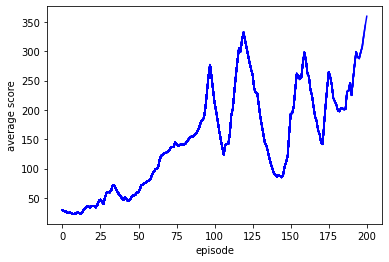

In [270]:
if __name__ == "__main__":
    env.reset()
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)
    #agent.model.load_weights('./save_model/model')
    scores, episodes = [], []
    score_avg = 0

    num_episode = 200
    
    for e in range(num_episode+1):
        if e % 10 == 0 and e != 0:
        #   show_video(0)
            env.play()

        done = False
        score = 0

        state = env.reset()
        state = state.reshape(1, -1)
        
        while not done:
            env.render()
  
            action = agent.choose_action(state)

            next_state, reward, done, info = env.step(action)
            next_state = next_state.reshape(1, -1)

            score += reward
            reward = 0.1 if not done or score == 500 else -1

            agent.remember(state, action, reward, next_state, done)

            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            state = next_state

            if done:
                agent.update_target_model()

                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print('episode: {:3d} | score avg {:3.2f} | memory length: {:4d} | epsilon: {:.4f}'.format(e, score_avg, len(agent.memory), agent.epsilon))

                scores.append(score_avg)
                episodes.append(e)
                plt.plot(episodes, scores, 'b')
                plt.xlabel('episode')
                plt.ylabel('average score')
                plt.savefig('cartpole_graph.png')
                env.close()
                if score_avg  > 400:
                    agent.model.save_weights('./save_model/model', save_format='tf')
                    sys.exit()

In [271]:
env.close()